In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.4.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/anaconda3/envs/ai4chem/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/usr/local/anaconda3/envs/ai4chem/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/usr/local/anaconda3/envs/ai4chem/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 758, in start
    self.io

# Tensors & Autograd

1.1 Why Tensors?
What to say (conceptual)

In PyTorch, everything is a tensor: inputs, parameters, outputs, gradients.
A tensor is just a multi-dimensional array plus information needed for differentiation and acceleration.

Compare to NumPy:

* Same idea as `np.ndarray`
* But:

    * Knows about gradients
    * Can live on GPU
    * Can participate in a computational graph

In [5]:
x = torch.tensor([1.0, 2.0, 3.0])
A = torch.randn(3, 3)

print(x)
print(x.shape, A.shape)
print(x.dtype)
print(x.device)

tensor([1., 2., 3.])
torch.Size([3]) torch.Size([3, 3])
torch.float32
cpu


In [6]:
# Tensor Operations & Broadcasting

x = torch.randn(5)
y = torch.randn(5)

z = x + y
w = x * y
print(z.shape,x.shape)

# Matrix operations:
A = torch.randn(4, 3)
B = torch.randn(3, 2)
C = A @ B
print(C.shape)

# Broadcasting
x = torch.randn(4, 3)
y = torch.randn(3)  
z = x + y
print(z.shape)
print(x)
print(y)
print(z)

torch.Size([5]) torch.Size([5])
torch.Size([4, 2])
torch.Size([4, 3])
tensor([[-1.7917,  1.6690,  2.5717],
        [-0.7770,  0.9734,  1.9033],
        [ 2.0456,  1.3837,  1.2479],
        [-0.4538,  0.6920,  1.5942]])
tensor([2.5500, 1.2421, 0.2769])
tensor([[0.7583, 2.9111, 2.8487],
        [1.7731, 2.2155, 2.1803],
        [4.5957, 2.6258, 1.5248],
        [2.0962, 1.9341, 1.8712]])


## Introducing Autograd
In PyTorch, autograd is the built-in automatic differentiation engine that powers all neural network training. It allows for the automatic computation of the gradient of any scalar value (like a loss function) with respect to all variables (like model parameters) that contributed to its computation. <br>

[Introduction to Autograd](https://docs.pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)

$$
y = x^2 + 3x + 1
$$
and
$$
\frac{\partial y}{\partial x} = 2x + 3
$$

* Every operation creates a node
* The graph is built during the forward pass
* `backward()` applies the chain rule automatically

In [7]:
x = torch.tensor(2.0, requires_grad=True)
y = x**2 + 3*x + 1
y.backward()
print(x.grad)

tensor(7.)


## Gradient Accumulation
* Gradients accumulate
* Torch assumes you want to sum gradients

$$
\frac{\partial x^2}{\partial x} = 2x \quad \text{and} \quad \frac{\partial x^3}{\partial x} = 3x^2  
$$

PyTorch literally does:<br>
`x.grad += new_gradient`

In [8]:
x = torch.tensor(2.0, requires_grad=True)

y1 = x**2
y1.backward()
print(x.grad)  # 2x = 4

# x.grad.zero_() # uncomment this line

y2 = x**3
y2.backward()
print(x.grad)  # 4 + 3x^2 = 16

tensor(4.)
tensor(16.)


We can use gradient accumulation for multiple loss terms, 
$$
{\cal L} = {\cal L}_{\text{MSE}} + \lambda {\cal L}_{\text{regularization}}
$$

# Feed Forward Neural Networks
We will build a **PIP-NN**, permutationally invariant polynomial neural network.

1. **Data loader**: provides an iterable over the data samples, simplifying and optimizing the process of feeding data to a model during training or evaluation
2. **Model**: Feed Forward Neural Network
3. **Training loop**: Main part of training stage

### Data loader

In [9]:
# load data using pandas
from sklearn.model_selection import train_test_split
data_file = 'https://raw.githubusercontent.com/ChemAI-Lab/Math4Chem/main/website/Assignments/CH4_data.csv'
data = pd.read_csv(data_file)
data.head()

# 1. How many points does the dataset contains?
n = data.shape[0]
print('The dataset contains {} points.'.format(n))

# Load PIPs representation per molecule
y_all = data['energy'].to_numpy()
print('Total energy points:', y_all.shape)
X_all = data.drop(['energy', 'Unnamed: 0'], axis=1).to_numpy()
print("Total Geometries:", X_all.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.3, random_state=42)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

The dataset contains 9000 points.
Total energy points: (9000,)
Total Geometries: (9000, 30)
Training set size: (6300, 30)
Test set size: (2700, 30)


In [10]:
# -----------------------------
# 1) Dataset
# -----------------------------
class PIPDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
dataset_tr = PIPDataset(X_train, y_train)
dataset_test = PIPDataset(X_test, y_test)

batch_size = 128

loader = DataLoader(
    dataset_tr,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False
)

# Test/validation loader (no shuffle)
test_loader = DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

for i,(X_batch, y_batch) in enumerate(loader):
    print(X_batch.shape)  # (batch_size, D)
    print(y_batch.shape)  # (batch_size, 1)
    print(X_batch[:3])
    print(y_batch[:3])
    if i > 1:
        break

torch.Size([128, 30])
torch.Size([128, 1])
tensor([[1.0000e+00, 2.0345e-01, 4.7021e-02, 1.5515e-02, 4.7844e-03, 1.8211e-04,
         4.7820e-03, 7.3652e-04, 1.0362e-02, 3.7369e-04, 5.2563e-04, 1.2164e-04,
         4.8637e-04, 3.7051e-05, 1.2153e-04, 3.7484e-05, 7.4922e-05, 5.7013e-06,
         1.9188e-06, 3.7440e-05, 1.9243e-06, 1.5797e-03, 2.4375e-04, 2.4348e-04,
         3.8026e-05, 2.8616e-06, 3.8001e-05, 1.1700e-05, 5.2843e-04, 3.0093e-06],
        [1.0000e+00, 2.1653e-01, 5.4913e-02, 1.7322e-02, 5.9273e-03, 2.7113e-04,
         5.9631e-03, 9.5792e-04, 1.2241e-02, 5.5734e-04, 6.0732e-04, 1.5786e-04,
         6.3318e-04, 5.8708e-05, 1.6019e-04, 5.1338e-05, 1.0386e-04, 9.1450e-06,
         2.5760e-06, 5.2222e-05, 2.5743e-06, 1.9289e-03, 3.3455e-04, 3.3763e-04,
         6.0242e-05, 5.7436e-06, 6.0438e-05, 1.8862e-05, 7.2163e-04, 5.9997e-06],
        [1.0000e+00, 2.1446e-01, 5.2470e-02, 1.7166e-02, 5.5929e-03, 2.3899e-04,
         5.6598e-03, 8.9327e-04, 1.1661e-02, 4.8862e-04, 6.0784e

## Stochastic approximation of MSE
Commonly in ML, we do not use "clean" gradient, we usually use a subset of the data (mini-batch) to approximate the gradient

$$
\nabla {\cal L} \approx \frac{1}{B} \sum_i^B \nabla {\cal L}_i
$$
where ${\cal L}_i$ is the mean square error for each point in the mini-batch ($B$).

In [12]:
# build a simple two layer neural network classifier using PyTorch (Sequential in a class)
class SimpleNNSequential(nn.Module):
    def __init__(self, input_size=2, hidden_size=2, output_size=1):
        super(SimpleNNSequential, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        return self.net(x)

In [13]:
# --- Model / Optim / Loss
pipnn_model = SimpleNNSequential(input_size=X_train.shape[1], hidden_size=64, output_size=1)
print(pipnn_model)

lr = 2E-3
weight_decay = 1E-5
optimizer = torch.optim.AdamW(pipnn_model.parameters(), 
                              lr=lr, 
                              weight_decay=weight_decay)
loss_fn = nn.MSELoss()

# # --- LR scheduler (optional but nice)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=8)


SimpleNNSequential(
  (net): Sequential(
    (0): Linear(in_features=30, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


# Main training Loop

In [14]:
n_epochs = 120
train_losses = []
val_losses = []
for epoch in range(n_epochs):
    pipnn_model.train()
    epoch_loss = 0.0
    for i, (X_batch, y_batch) in enumerate(loader):
        optimizer.zero_grad()
        y_pred = pipnn_model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X_batch.size(0)
    epoch_loss /= len(dataset_tr)

    # Validation/test loss
    pipnn_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = pipnn_model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(dataset_test)

    train_losses.append(epoch_loss)
    val_losses.append(val_loss)


    # if (epoch) % 10 == 0:
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch [1/120], Loss: 1485.7707, Val Loss: 1096.4470
Epoch [2/120], Loss: 392.2292, Val Loss: 7.0159
Epoch [3/120], Loss: 2.6657, Val Loss: 0.1671
Epoch [4/120], Loss: 0.1760, Val Loss: 0.1650
Epoch [5/120], Loss: 0.1656, Val Loss: 0.1634
Epoch [6/120], Loss: 0.1636, Val Loss: 0.1621
Epoch [7/120], Loss: 0.1620, Val Loss: 0.1603
Epoch [8/120], Loss: 0.1602, Val Loss: 0.1581
Epoch [9/120], Loss: 0.1582, Val Loss: 0.1562
Epoch [10/120], Loss: 0.1563, Val Loss: 0.1547
Epoch [11/120], Loss: 0.1542, Val Loss: 0.1518
Epoch [12/120], Loss: 0.1517, Val Loss: 0.1494
Epoch [13/120], Loss: 0.1494, Val Loss: 0.1471
Epoch [14/120], Loss: 0.1467, Val Loss: 0.1447
Epoch [15/120], Loss: 0.1445, Val Loss: 0.1419
Epoch [16/120], Loss: 0.1416, Val Loss: 0.1394
Epoch [17/120], Loss: 0.1388, Val Loss: 0.1365
Epoch [18/120], Loss: 0.1359, Val Loss: 0.1336
Epoch [19/120], Loss: 0.1331, Val Loss: 0.1309
Epoch [20/120], Loss: 0.1304, Val Loss: 0.1279
Epoch [21/120], Loss: 0.1272, Val Loss: 0.1249
Epoch [22/120]

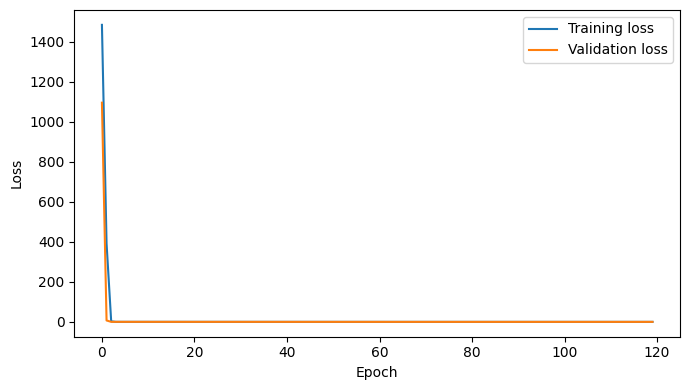

In [16]:
# Plot training and validation loss
plt.figure(figsize=(7, 4))
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
